In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [125]:
from PIL import Image, ImageFilter
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import random
import pickle

In [126]:
def get_preprocessed_train_data(data: list[Image.Image]) -> tuple[np.ndarray, list[PCA], StandardScaler]:
    """
    Preprocesses training data using fourier transform, PCA, and scaler
    """
    # Transform data to frequency domain
    data_fft = [np.fft.fft2(datum) for datum in data]
    
    # Initialize lists for each color channel
    data_r = []
    data_g = []
    data_b = []
    data_edge = []

    # Define filters
    lowpass_filter = ImageFilter.Kernel((3,3),
                                            (0, -1, 0,
                                            -1, 4, -1,
                                            0, -1, 0),
                                        1, 0)

    highpass_filter = ImageFilter.Kernel((5,5),
                                            (1/273, 4/273, 7/273, 4/273, 1/273,
                                            4/273, 16/273, 26/273, 16/273, 4/273,
                                            7/273, 26/273, 41/273, 26/273, 7/273,
                                            4/273, 16/273, 26/273, 16/273, 4/273,
                                            1/273, 4/273, 7/273, 4/273, 1/273),
                                        1, 0)
    
    # Append each color channel to the corresponding list
    for i in range(len(data)):
        data_r.append(abs(data_fft[i])[:, :, 0].flatten())
        data_g.append(abs(data_fft[i])[:, :, 1].flatten())
        data_b.append(abs(data_fft[i])[:, :, 2].flatten())

        # Apply filters to each image and append to the edge list
        data_edge.append(np.array(data[i].convert("L").filter(lowpass_filter).filter(highpass_filter)).flatten())

    # Initialize PCA objects
    pca_r = PCA(n_components=16) 
    pca_g = PCA(n_components=16)
    pca_b = PCA(n_components=16)
    pca_edge = PCA(n_components=2)


    # Fit PCA objects to each color channel
    data_r = pca_r.fit_transform(data_r)
    data_g = pca_g.fit_transform(data_g)
    data_b = pca_b.fit_transform(data_b)
    data_edge = pca_edge.fit_transform(data_edge)

    # Combine all color channels and edge data
    data_combined = np.concatenate((data_r, data_g, data_b, data_edge, (data_r + data_g + data_b) / 3), axis=1)

    # Scale data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_combined)

    # Return scaled data, PCA objects, and scaler
    return data_scaled, [pca_r, pca_g, pca_b, pca_edge], scaler


def get_preprocessed_test_data(data: list[Image.Image], pcas: list[PCA], scaler: StandardScaler) -> np.ndarray:
    """
    Preprocesses test data using PCA objects and scaler from training data
    """

    # Transform data to frequency domain
    data_fft = [np.fft.fft2(datum) for datum in data]
    
    # Initialize lists for each color channel
    data_r = []
    data_g = []
    data_b = []
    data_edge = []

    # Define filters
    lowpass_filter = ImageFilter.Kernel((3,3),
                                            (0, -1, 0,
                                            -1, 4, -1,
                                            0, -1, 0),
                                        1, 0)

    highpass_filter = ImageFilter.Kernel((5,5),
                                            (1/273, 4/273, 7/273, 4/273, 1/273,
                                            4/273, 16/273, 26/273, 16/273, 4/273,
                                            7/273, 26/273, 41/273, 26/273, 7/273,
                                            4/273, 16/273, 26/273, 16/273, 4/273,
                                            1/273, 4/273, 7/273, 4/273, 1/273),
                                        1, 0)

    # Append each color channel to the corresponding list
    for i in range(len(data)):
        data_r.append(abs(data_fft[i])[:, :, 0].flatten())
        data_g.append(abs(data_fft[i])[:, :, 1].flatten())
        data_b.append(abs(data_fft[i])[:, :, 2].flatten())
        data_edge.append(np.array(data[i].convert("L").filter(lowpass_filter).filter(highpass_filter)).flatten())

    # Initialize PCA objects
    pca_r = None
    pca_g = None
    pca_b = None
    pca_edge = None

    try:
        # Get PCA objects from pcas argument
        pca_r = pcas[0]
        pca_g = pcas[1]
        pca_b = pcas[2]
        pca_edge = pcas[3]
    except IndexError:
        raise Exception("pcas argument is invalid. pcas should be a list of pca_r, pca_g, and pca_b")

    # Transform data using PCA objects
    data_r = pca_r.transform(data_r)
    data_g = pca_g.transform(data_g)
    data_b = pca_b.transform(data_b)
    data_edge = pca_edge.transform(data_edge)

    # Combine all color channels and edge data
    data_combined = np.concatenate((data_r, data_g, data_b, data_edge, (data_r + data_g + data_b) / 3), axis=1)

    # Scale data
    data_scaled = scaler.transform(data_combined)

    return data_scaled



In [127]:
def list_full_dir(path):
    return [path + f for f in os.listdir(path)]

In [128]:
# ambulance_dirs = list_full_dir('dataset_2_without_txt/ambulance')
bus_dirs = list_full_dir('dataset_2_without_txt/bus/') \
    + list_full_dir('dataset/train/bus/') \
        + list_full_dir('dataset/valid/bus/') \
            + list_full_dir('dataset/test_labeled/bus/') \
    + list_full_dir('dataset_3/train/bus/') \
            + list_full_dir('dataset_3/test_labeled/bus/') 

truck_dirs = list_full_dir('dataset_2_without_txt/truck/') \
    + list_full_dir('dataset/train/truck/') \
        + list_full_dir('dataset/valid/truck/') \
            + list_full_dir('dataset/test_labeled/truck/') \
    + list_full_dir('dataset_3/train/truck/') \
            + list_full_dir('dataset_3/test_labeled/truck/') 

car_dirs = list_full_dir('dataset_2_without_txt/car/') \
    + list_full_dir('dataset/train/car/') \
        + list_full_dir('dataset/valid/car/') \
            + list_full_dir('dataset/test_labeled/car/') \
    + list_full_dir('dataset_3/train/car/') \
            + list_full_dir('dataset_3/test_labeled/car/') 

# Downsample car
# random.seed(0)
# car_dirs = random.sample(car_dirs, 800)

In [129]:
print(len(bus_dirs))
print(len(truck_dirs))
print(len(car_dirs))

620
541
1174


In [130]:
label2id = {
    "ambulance": 0,
    "bus": 1,
    "car": 2,
    "truck": 3
}

id2label = {label2id[k]: k  for k in label2id}

In [131]:
X = []
y = []
# for ambulance_dir in ambulance_dirs:
#     X.append(Image.open('dataset_2_without_txt/ambulance/' + ambulance_dir).resize((256, 256)))
#     y.append(0)
for bus_dir in bus_dirs:
    X.append(Image.open(bus_dir).resize((256, 256)))
    y.append(1)
for car_dir in car_dirs:
    X.append(Image.open(car_dir).resize((256, 256)))
    y.append(2)
for truck_dir in truck_dirs:
    X.append(Image.open(truck_dir).resize((256, 256)))
    y.append(3)


In [132]:
len(X)

2335

In [133]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [134]:
X_train, pcas, scaler = get_preprocessed_train_data(X_train_raw)

In [135]:
X_test = get_preprocessed_test_data(X_test_raw, pcas, scaler)

In [136]:
model = RandomForestClassifier(n_estimators = 3, criterion = 'log_loss', random_state = 42)
history = model.fit(X_train, y_train)

In [137]:
y_pred = model.predict(X_test)

In [138]:
y_pred = model.predict(X_test)
count = 0
for i in range(len(y_pred)):
    # print(f"Prediction={y_pred[i]}|Actual={y_test[i]}")
    if y_pred[i] == y_test[i]:
        count+=1

print(count/len(y_pred))

0.8461538461538461


In [139]:
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted   1    2   3
Actual                
1          77   17   5
2           7  154   5
3          11    9  66


In [182]:
model_svc = SVC(kernel='rbf', C=4)
history_svc = model_svc.fit(X_train, y_train)

y_pred = model_svc.predict(X_test)
count = 0
for i in range(len(y_pred)):
    # print(f"Prediction={y_pred[i]}|Actual={y_test[i]}")
    if y_pred[i] == y_test[i]:
        count+=1

print(count/len(y_pred))

0.9230769230769231


In [183]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted   1    2   3
Actual                
1          88   10   1
2           3  159   4
3           1    8  77


In [184]:
label2id

{'ambulance': 0, 'bus': 1, 'car': 2, 'truck': 3}

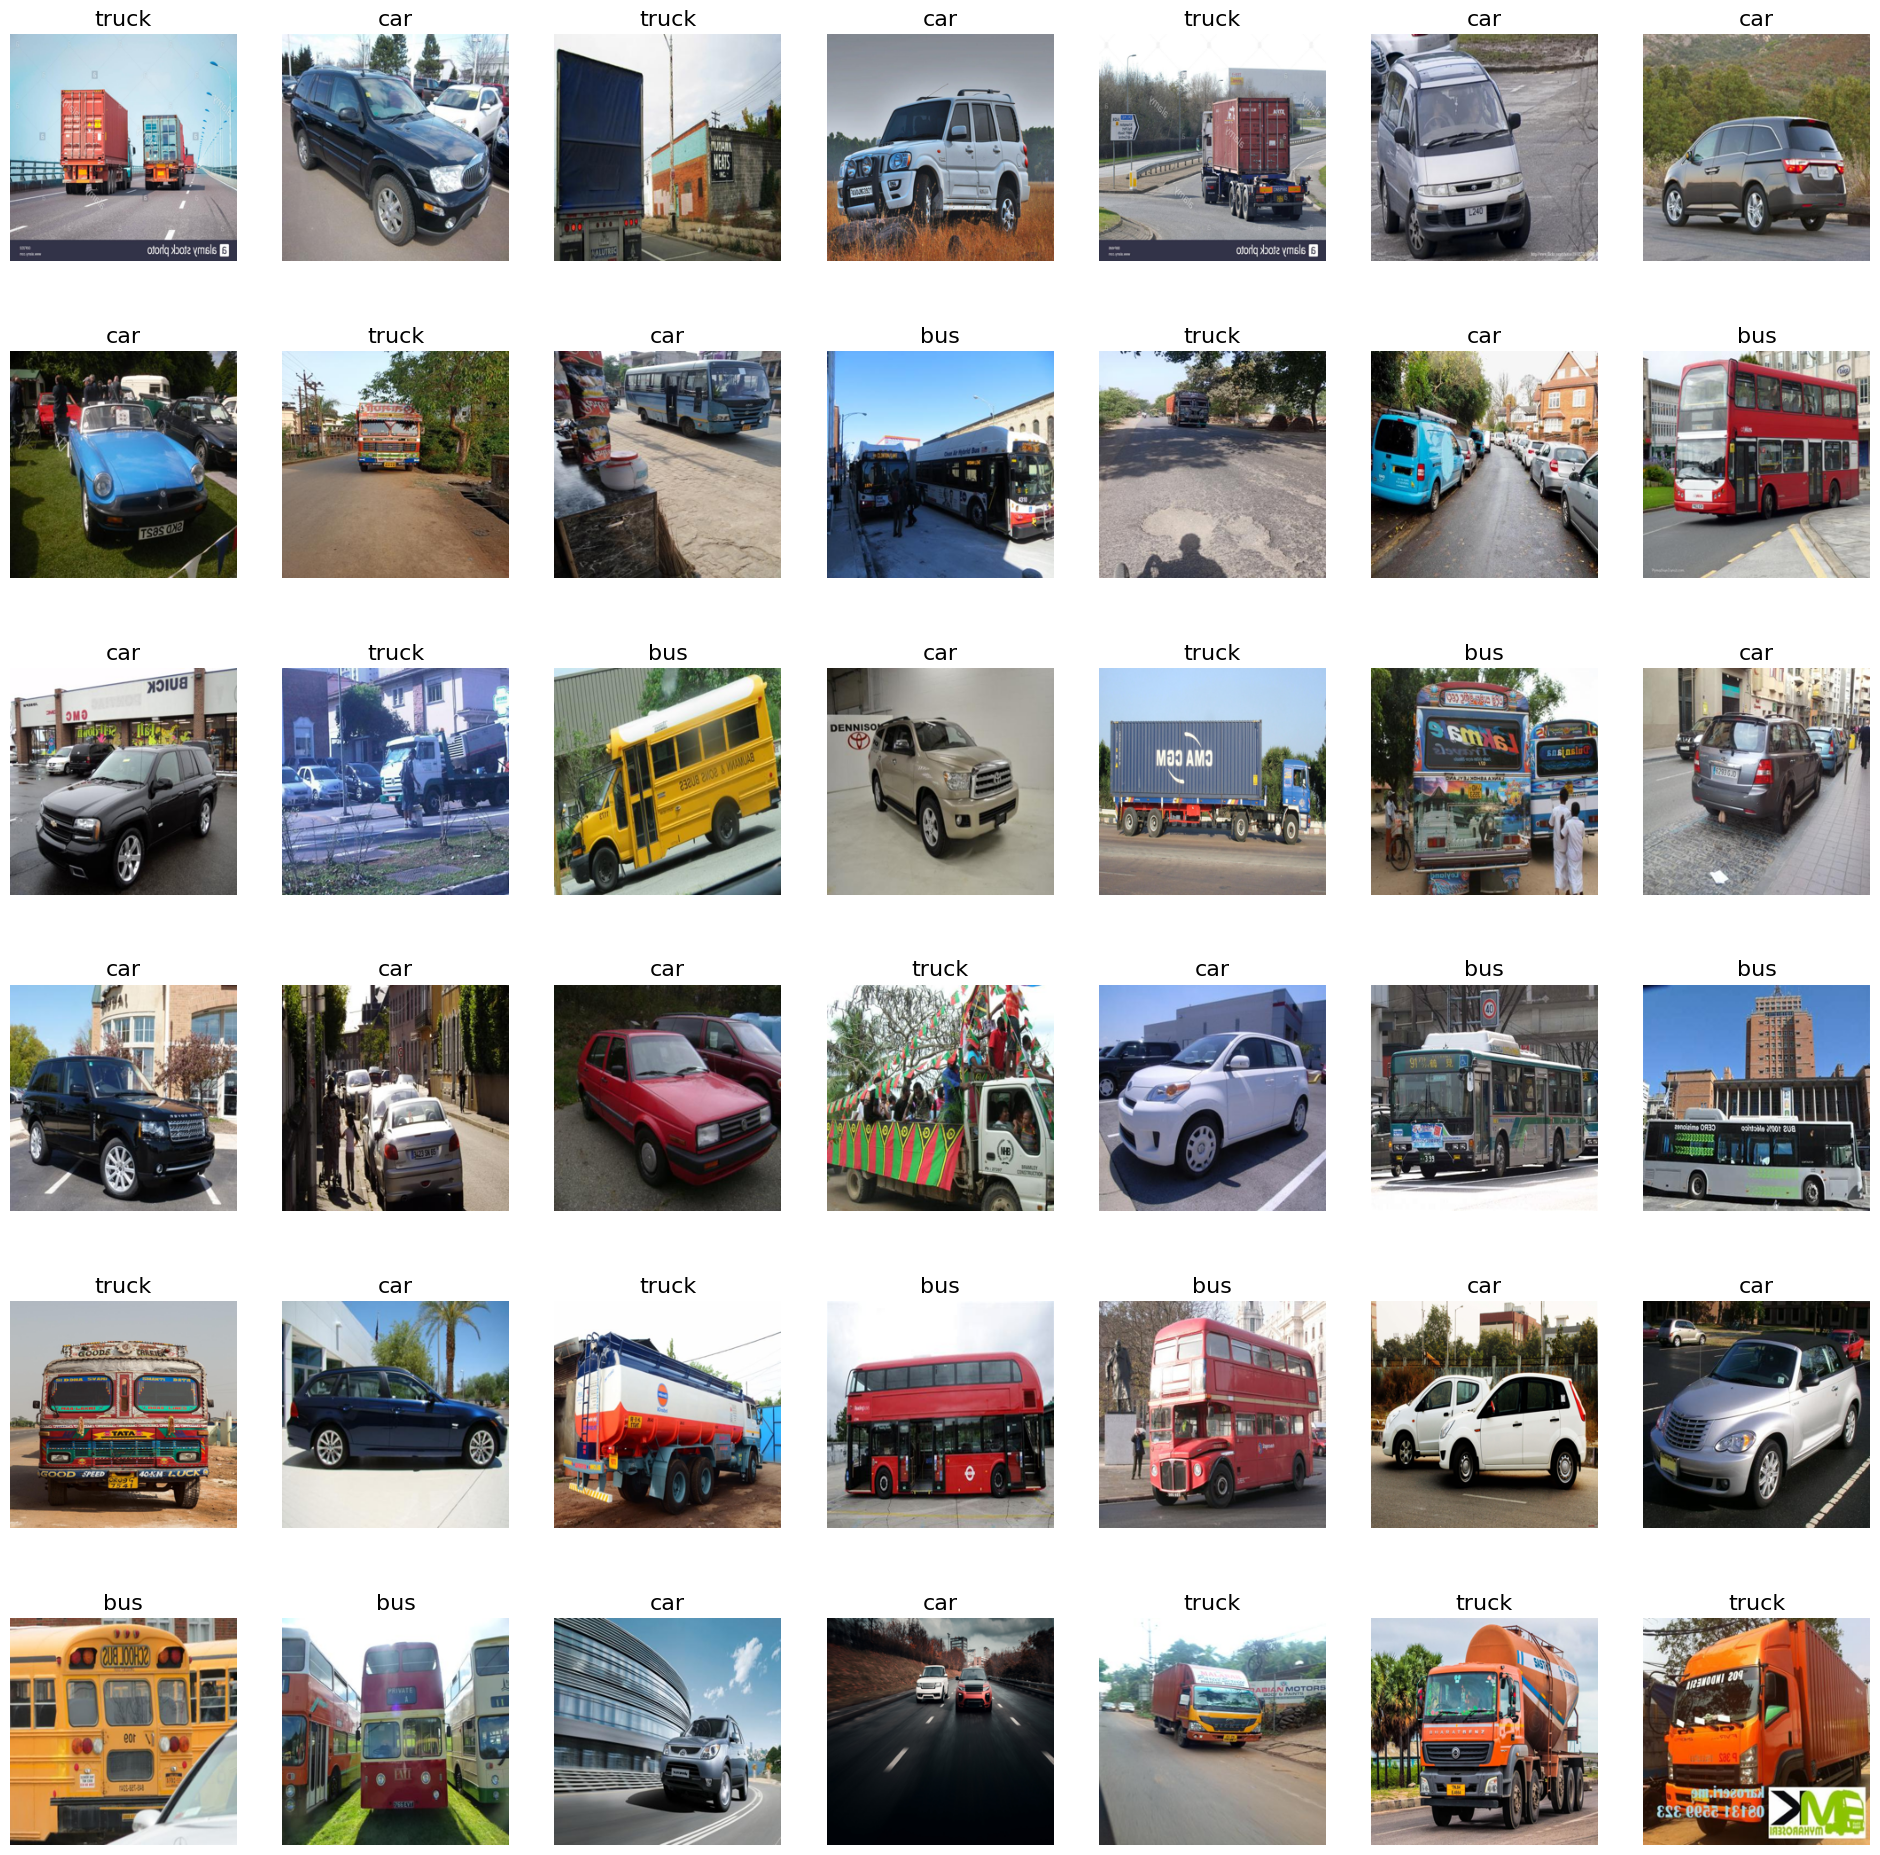

In [185]:
_, axs = plt.subplots(6, 7, figsize=(24, 24))
axs = axs.flatten()
for i in range(42):
    imgplot = axs[i].imshow(X_test_raw[i])
    axs[i].set_title(id2label[y_pred[i]], fontsize=16)
    axs[i].axis('off')
plt.show()

In [186]:
test_img_dirs = os.listdir("test")

In [187]:
test_imgs = []

for d in test_img_dirs:
    test_imgs.append(Image.open('test/' + d).resize((256, 256)))


In [188]:
test_data = get_preprocessed_test_data(test_imgs, pcas, scaler)

In [189]:
test_pred = model_svc.predict(test_data)

In [190]:
test_pred

array([2, 1, 1, 2, 3, 2])

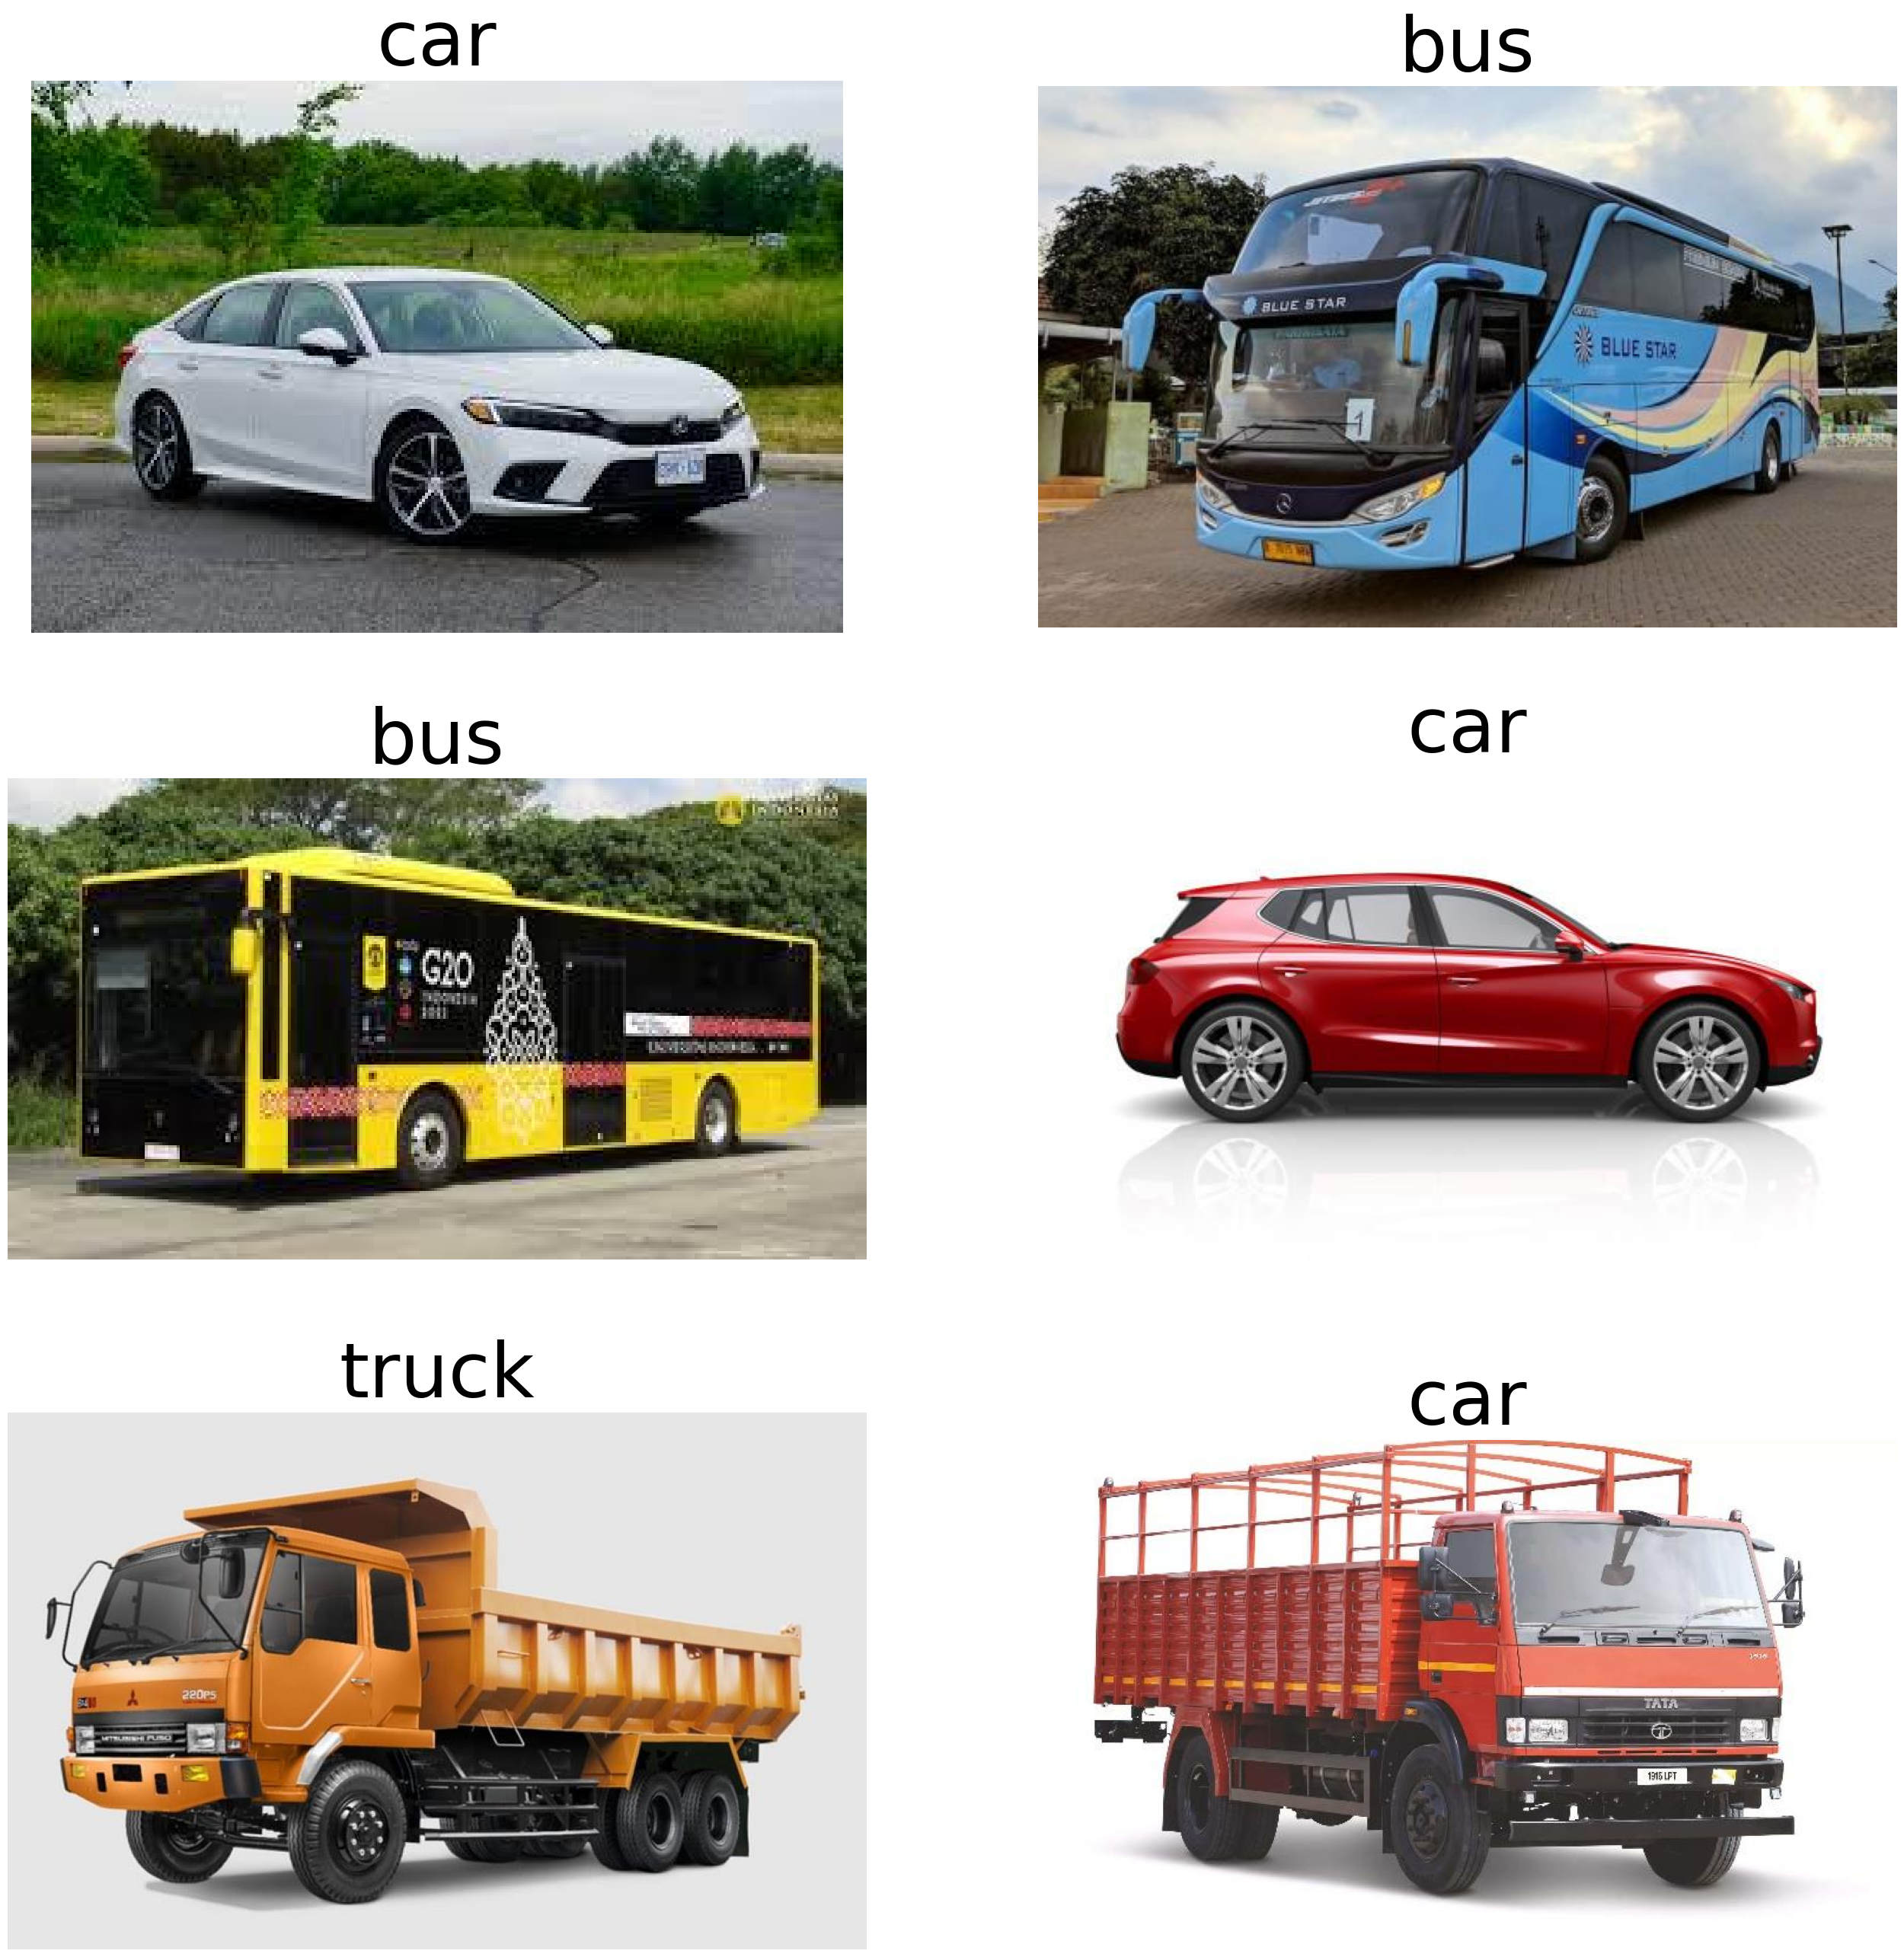

In [191]:
import matplotlib.image as mpimg

labels = [id2label[y] for y in test_pred]

_, axs = plt.subplots(3, 2, figsize=(32, 32))
axs = axs.flatten()
for i in range(6):
    img = mpimg.imread("test/" + test_img_dirs[i])
    imgplot = axs[i].imshow(img)
    axs[i].set_title(labels[i], fontsize=72)
    axs[i].axis('off')
plt.show()